In [1]:
%run notebook_setup

/home/circleci/project/docs/examples/notebook_setup.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Reproducing Swihart et al. 2019

In this science demo tutorial, we will reproduce the results in [Swihart et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...876....8S/abstract), who used optical spectroscopic follow-up of a companion to a millisecond pulsar to constrain the mass of the pulsar. We will use *The Joker* to constrain the orbit of the system, assuming circular orbits (as done in the paper), and then continue sampling using MCMC (as implemented in pymc3) to compare our results.

First, a bunch of imports we will need later:

In [2]:
from astropy.io import ascii
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pymc3 as pm
import pymc3_ext as pmx
import exoplanet.units as xu
import exoplanet as xo
from pymc3_ext.distributions import Angle
import corner
import arviz as az

import thejoker as tj

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# set up a random number generator to ensure reproducibility
seed = 42
rnd = np.random.default_rng(seed=seed)

## Load the data

We will start by loading the radial velocity data from SOAR/Goodman, copy-pasted from Table 1 in Swihart et al. 2019):

In [4]:
tbl = ascii.read(
    """2457945.5419639 -119.5 6.5
    2457945.6301728 -16.9 7.2
    2457956.5212405 -123.1 6.8
    2457956.5352468 -107.9 6.4
    2457956.5546942 -95.8 8.1
    2457956.5687017 -65.6 8.2
    2457956.5948590 -57.2 7.0
    2457956.6088705 -38.0 6.0
    2457966.4981876 -27.2 7.6
    2457966.5122271 -18.4 20.1
    2457966.5399208 38.7 7.2
    2457966.5608956 49.6 8.7
    2457966.5914866 115.1 10.2
    2457967.5998999 -1.5 12.8
    2457996.4786139 231.8 8.4
    2457996.4931540 238.7 8.0
    2457996.5105239 228.8 9.4
    2458001.4795192 -144.0 11.4
    2458001.4935388 -124.6 10.2
    2458139.7564130 -136.8 7.7
    2458139.7704090 -117.1 6.8
    2458140.7400266 -194.5 9.8
    2458140.7540222 -166.4 8.3
    2458140.7770050 -150.8 7.4
    2458140.7910007 -158.5 8.2
    2458161.6721983 -121.2 7.9
    2458161.6872977 -107.7 7.3
    2458202.5822163 177.8 8.5
    2458202.5962046 197.7 9.6
    2458202.8350917 190.9 7.4
    2458202.8490793 176.1 7.6
    2458223.5928781 231.9 7.7
    2458223.8317433 41.2 8.4
    2458223.8456941 32.1 14.9
    2458243.6779211 -87.6 8.6
    2458243.6919415 -112.3 10.5
    2458243.7115353 -125.5 9.5
    2458243.7263475 -141.9 10.2
    2458243.7459698 -130.3 10.9
    2458247.5062024 131.9 11.5
    2458247.5435496 160.5 14.2
    2458278.5472619 197.1 15.9
    2458278.5613912 183.7 15.7""", 
    names=['BJD', 'rv', 'rv_err'])
tbl['rv'].unit = u.km/u.s
tbl['rv_err'].unit = u.km/u.s

We set the scale to 'tcb' to indicate that these are barycentric julian dates:

In [5]:
data = tj.RVData(
    t=Time(tbl['BJD'], format='jd', scale='tcb'),
    rv=u.Quantity(tbl['rv']), 
    rv_err=u.Quantity(tbl['rv_err']))

Let's make a quick plot of the data:

<AxesSubplot: xlabel='time [BMJD]', ylabel='RV [$\\mathrm{km\\,s^{-1}}$]'>

findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


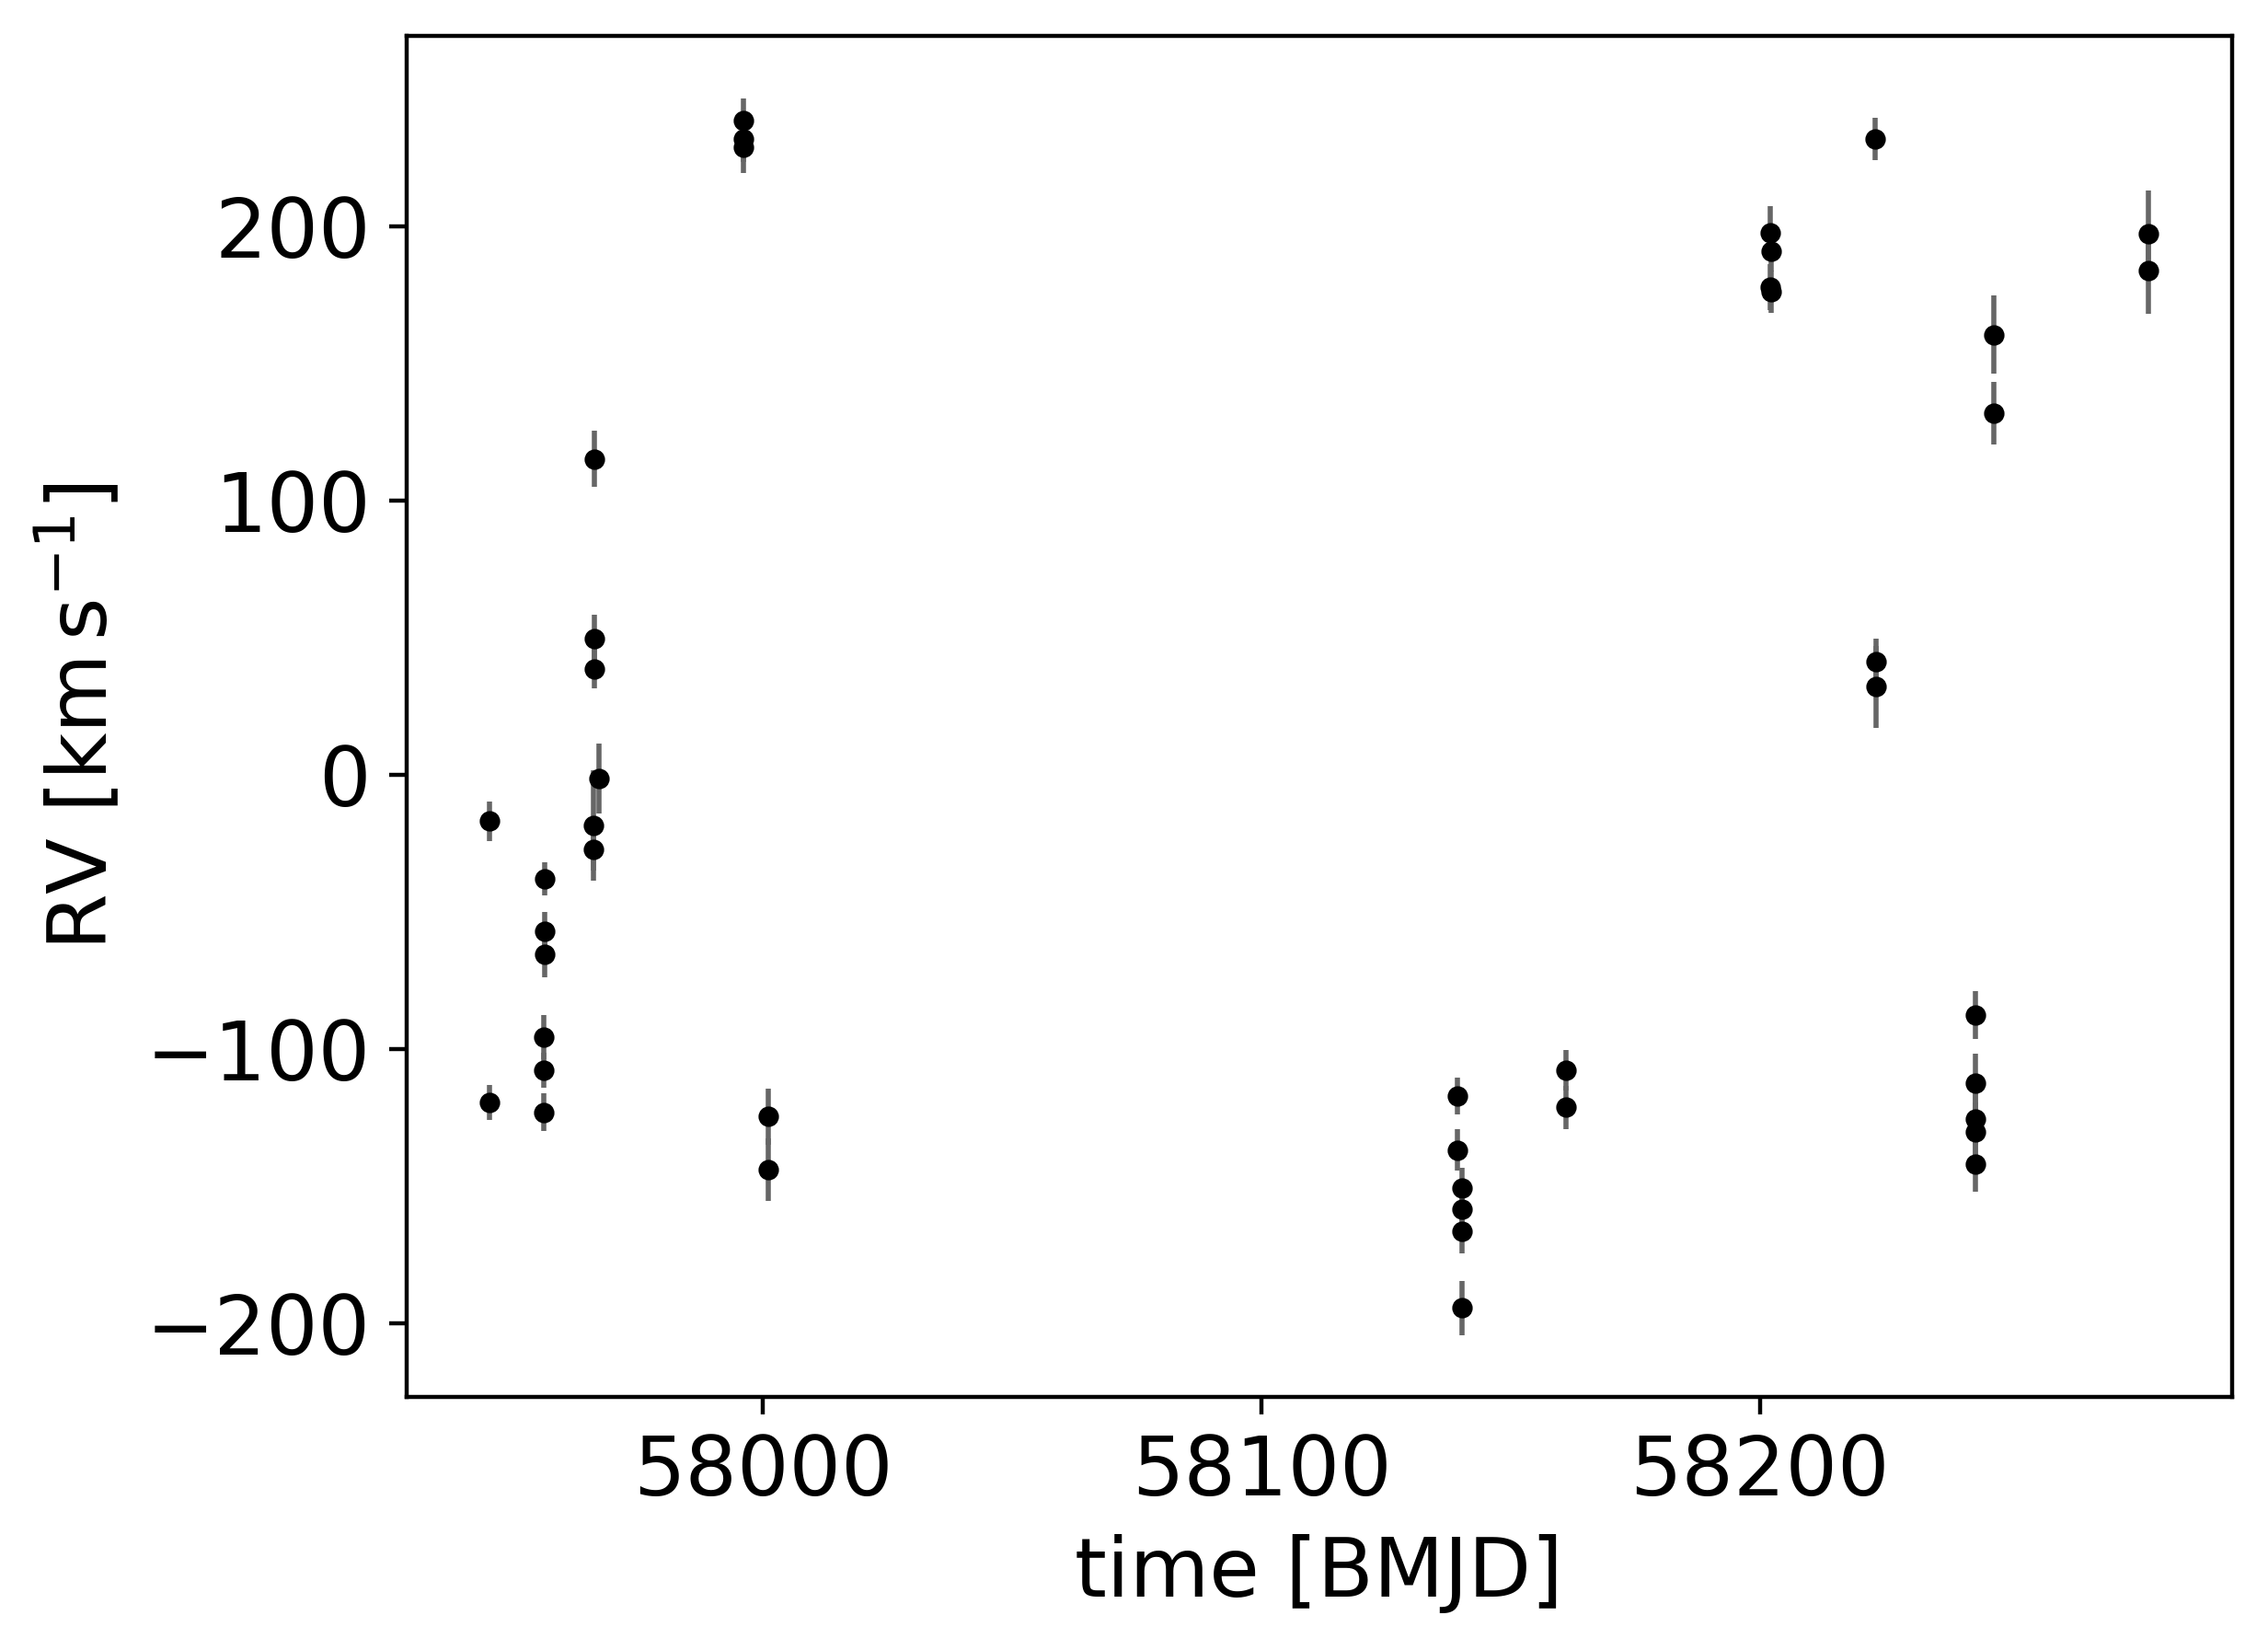

In [6]:
data.plot(markersize=3)

We now need to specify the prior probability distribution over the Keplerian orbital parameters. We will fix the eccentricity to 0, assuming that the system has circularized. We set the scale of the prior on K to be 50 km/s at a period of 1 year: The default prior on K depends on period and eccentricity in a way that keeps the implied prior over companion mass constant. These parameter choices imply a standard deviation in companion mass of ~1.5 Msun:

In [7]:
with pm.Model() as model:
    # Allow extra error to account for under-estimated error bars
    e = xu.with_unit(pm.Constant('e', 0), 
                     u.one)
    
    prior = tj.JokerPrior.default(
        P_min=0.1*u.day, P_max=100*u.day,  # Range of periods to consider
        sigma_K0=50*u.km/u.s, P0=1*u.year,  # scale of the prior on semiamplitude, K
        sigma_v=50*u.km/u.s,  # std dev of the prior on the systemic velocity, v0
        pars={'e': e}
    )

Now that we have defined the prior, we can run *The Joker* to generate posterior orbit samples:

In [8]:
# Run rejection sampling with The Joker:
joker = tj.TheJoker(prior, random_state=rnd)
samples = joker.rejection_sample(data, 
                                 prior_samples=100_000,
                                 max_posterior_samples=256)
samples

<JokerSamples [P, e, omega, M0, s, K, v0] (2 samples)>

Only one sample was returned, implying that this system is very well constrained. Let's plot the data and the orbit determined from that sample:

findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


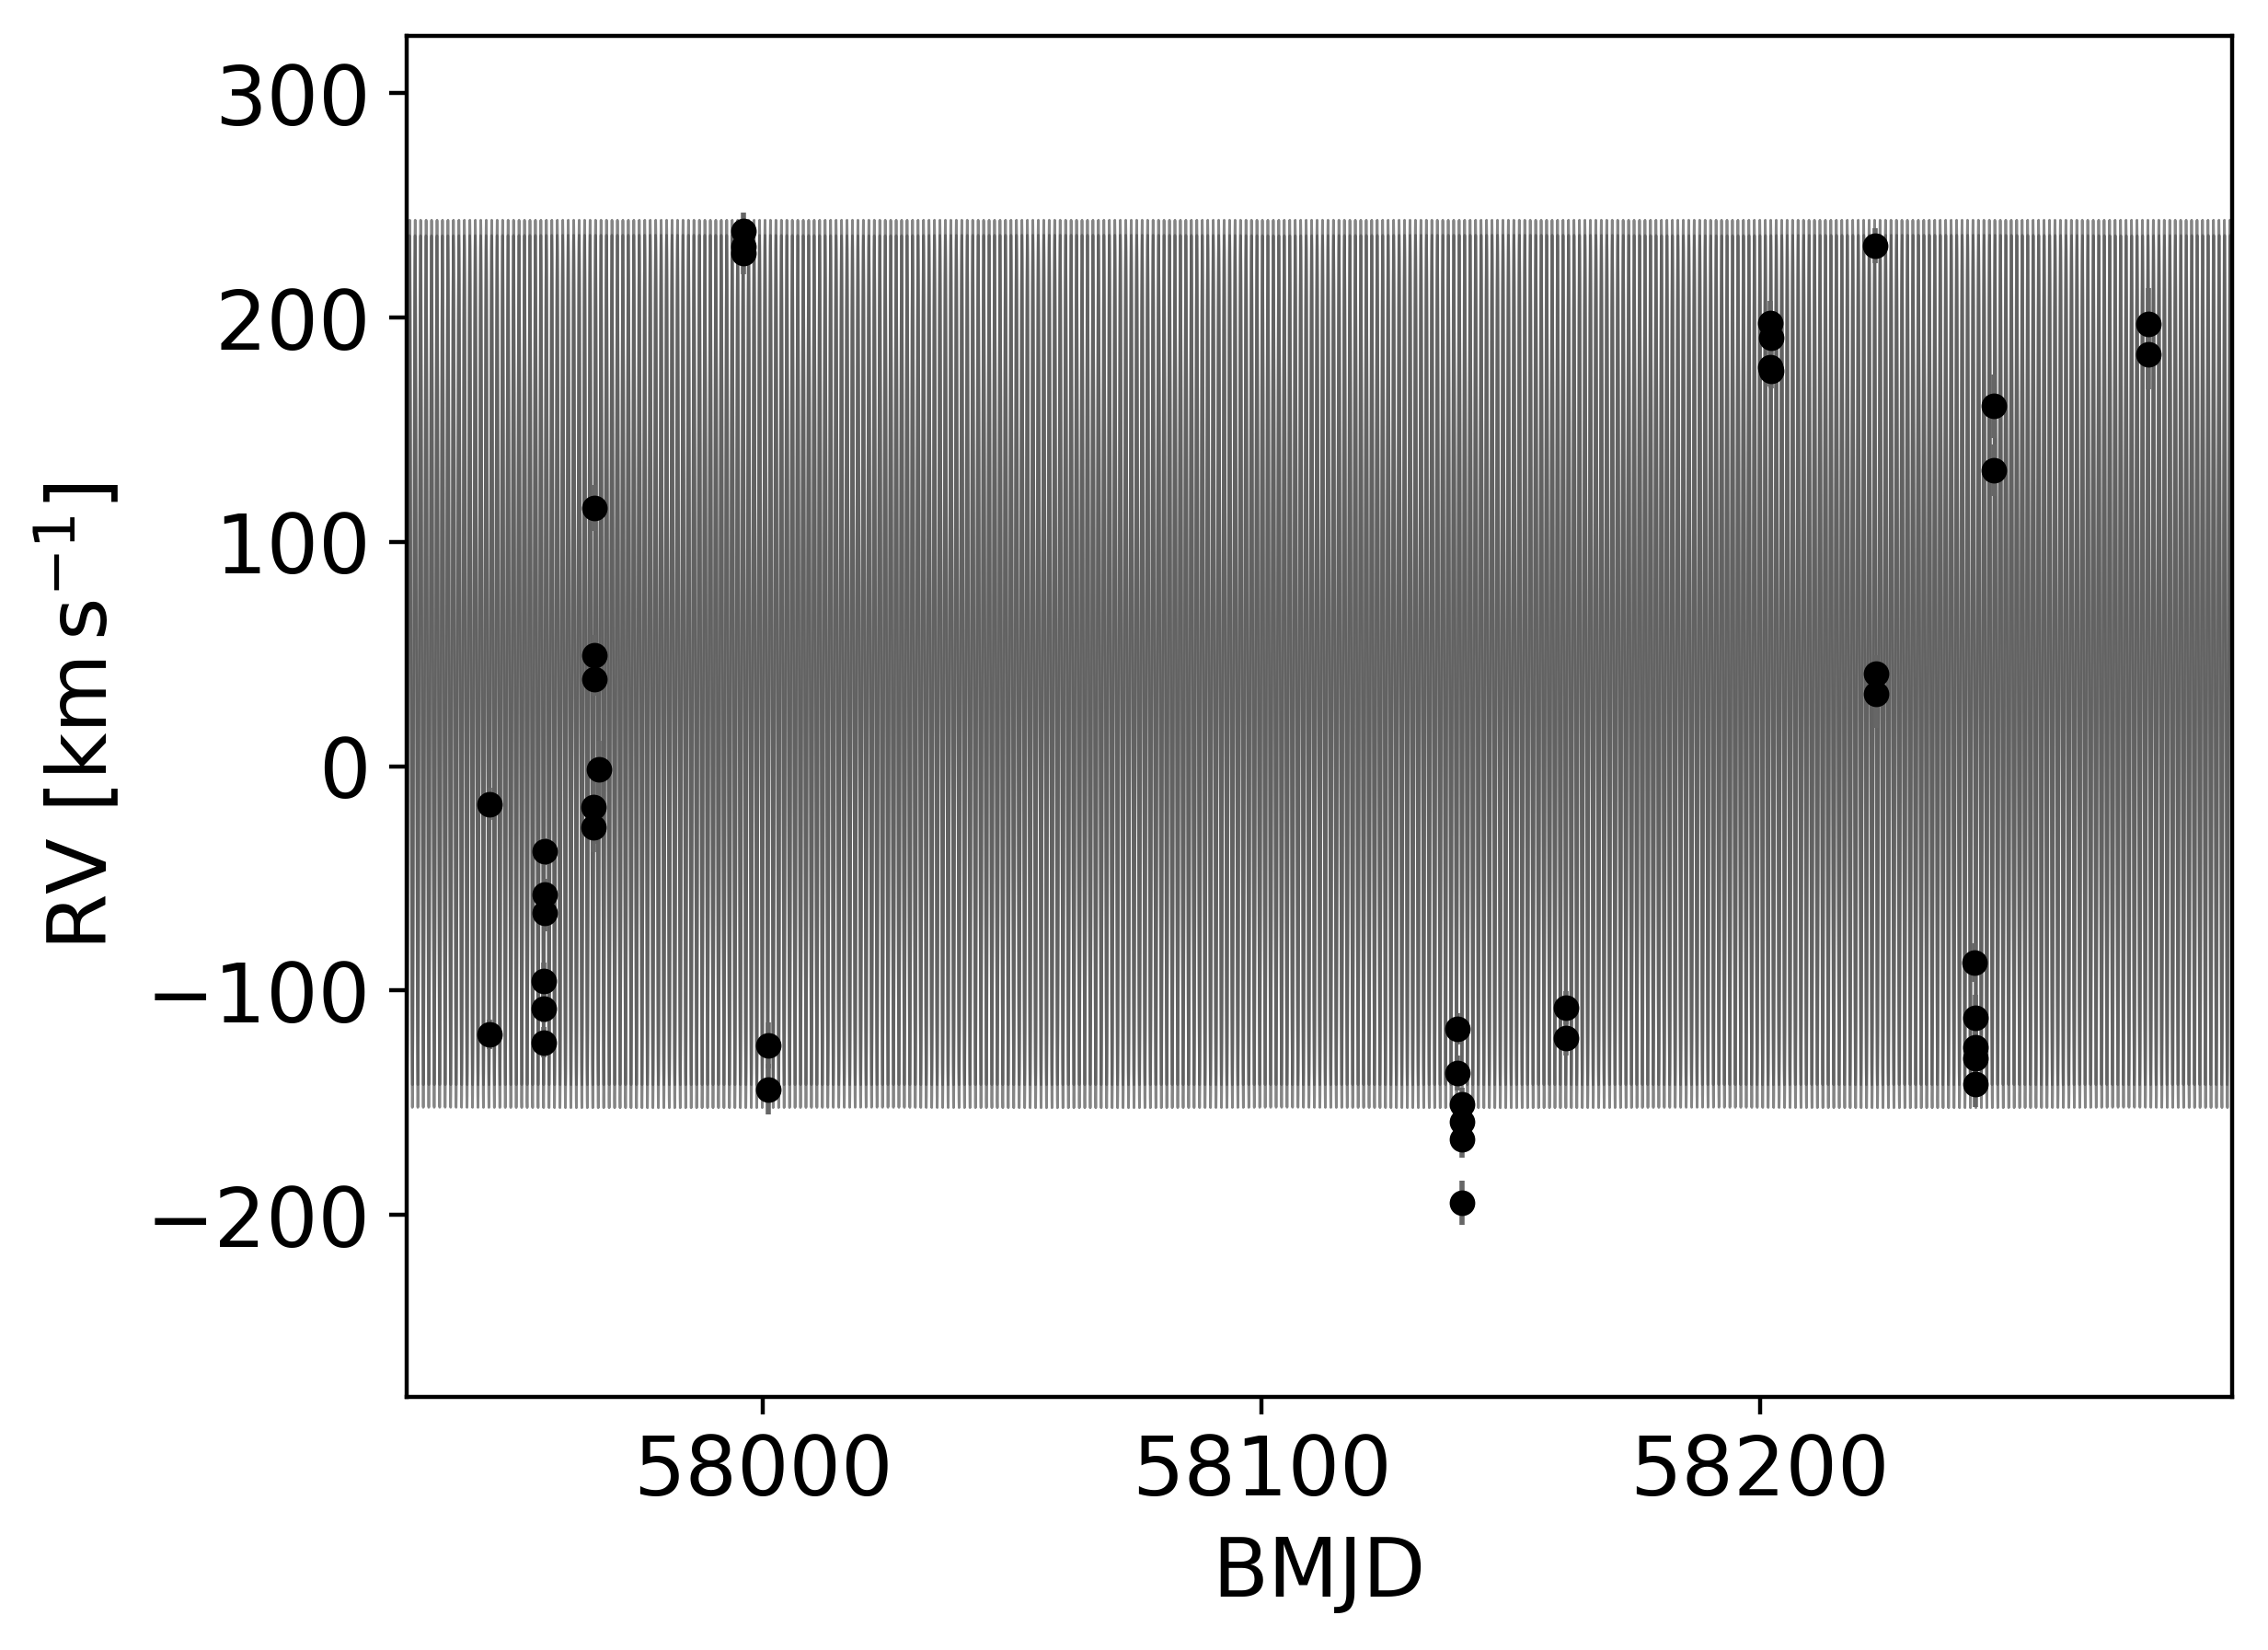

In [9]:
_ = tj.plot_rv_curves(samples, data=data)

Well, that plot isn't too useful! The period is very short and the baseline is long, so it is hard to see the orbit in the above solution. Let's instead plot the phase-folded orbit and data:

ValueError: You must specify an index when the number of samples is >1 (here, it's 2)

findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


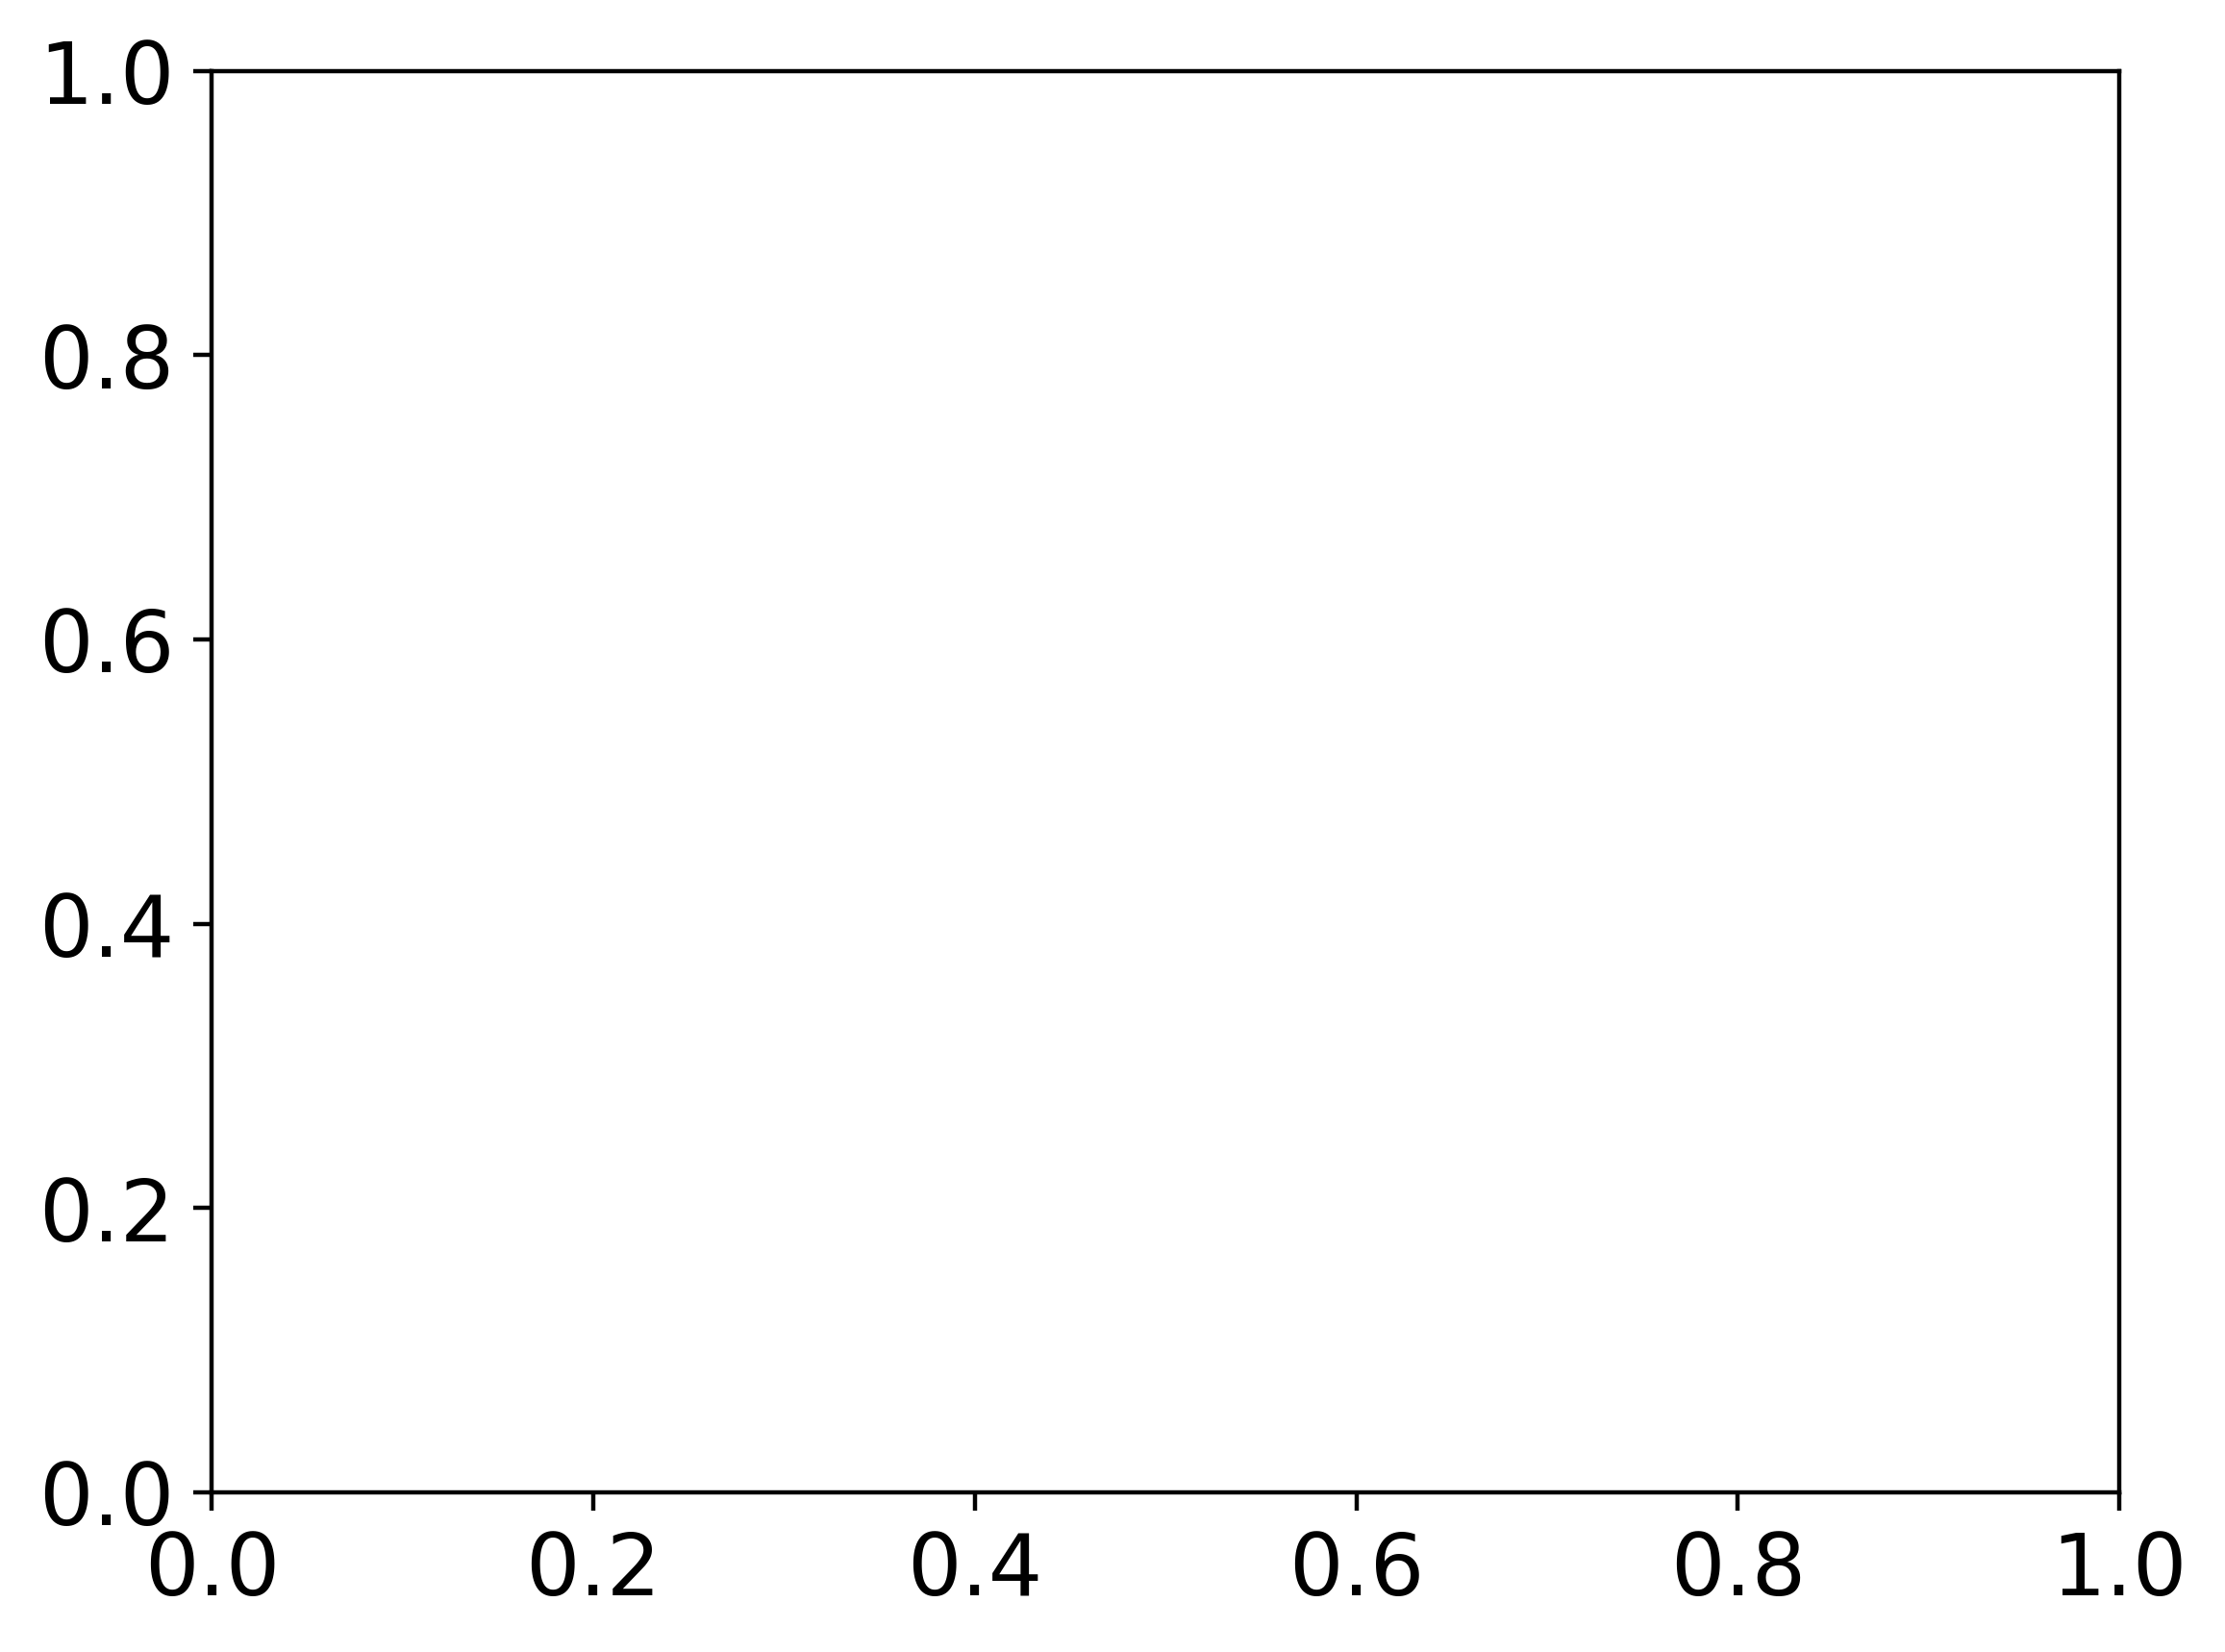

In [10]:
tj.plot_phase_fold(samples, data=data);

Only one sample is returned from *The Joker*, implying that the data are very constraining. We therefore switch to using standard MCMC to continue generating posterior samples. With the new version of *The Joker*, this is done with `pymc3`, which uses Hamiltonian Monte Carlo (and the NUTS sampler) to efficiently generate samples. Setting up the MCMC sampling is similar to setting up *The Joker*, and we will use the sample returned from *The Joker* to initialize the MCMC:

In [ ]:
import aesara_theano_fallback.tensor as tt
with pm.Model():
    
    # To sample with pymc3, we have to set any constant variables 
    # as "Deterministic" objects. We can ignore eccentricity and 
    # the argument of pericenter by setting them both to 0:
    e = xu.with_unit(pm.Deterministic('e', tt.constant(0)), 
                     u.one)
    omega = xu.with_unit(pm.Deterministic('omega', tt.constant(0)), 
                         u.radian)
    
    # We use the same prior parameters as before:
    prior_mcmc = tj.JokerPrior.default(
        P_min=0.1*u.day, P_max=10*u.day,
        sigma_K0=50*u.km/u.s, P0=1*u.year,
        sigma_v=50*u.km/u.s,
        pars={'e': e, 'omega': omega}
    )
    
    # Now we use the sample returned from The Joker to set up 
    # our initialization for standard MCMC:
    joker_mcmc = tj.TheJoker(prior_mcmc, random_state=rnd)
    mcmc_init = joker_mcmc.setup_mcmc(data, samples)
    
    trace = pmx.sample(
        tune=500, draws=1000,
        start=mcmc_init,
        random_seed=seed,
        cores=1, chains=2)

We can now use `arviz` to look at some statistics of the MC chains to assess convergence:

In [ ]:
az.summary(trace, var_names=prior_mcmc.par_names)

We can then transform the MCMC samples back into a `JokerSamples` instance so we can manipulate and visualize the samples:

In [ ]:
mcmc_samples = joker_mcmc.trace_to_samples(trace, data=data)
mcmc_samples.wrap_K()

For example, we can make a [corner](https://corner.readthedocs.io/en/latest/) plot of the orbital parameters (I remove any of the parameters we ignored):

In [ ]:
df = mcmc_samples.tbl.to_pandas()
df = df.drop(columns=['e', 's', 'omega'])

true_P = 1.097195
true_T0 = 2457780.8373
true_M0 = (2*np.pi * (true_T0 - data.t_ref.tcb.jd) / true_P) % (2*np.pi) - (2*np.pi)
_ = corner.corner(df, truths=[true_P, true_M0, 210, 32.0])

We can also use the median MCMC sample to fold the data and plot residuals relative to our inferred RV model:

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

_ = tj.plot_phase_fold(mcmc_samples.mean(), data, ax=axes[0], add_labels=False)
_ = tj.plot_phase_fold(mcmc_samples.mean(), data, ax=axes[1], residual=True)

for ax in axes:
    ax.set_ylabel(f'RV [{data.rv.unit:latex_inline}]')
    
axes[1].axhline(0, zorder=-10, color='tab:green', alpha=0.5)
axes[1].set_ylim(-50, 50)

In the end, it looks like we reproduce the results in Swihart et al. using their data and the new version of *The Joker*. A success for reproducible science!